In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from pprint import pprint
from keras.utils.np_utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


In [2]:
FILE_NAME = 'data.csv'
MAX_Q = 10

# Data have 5 scales:
#     +1   : True
#     +0.5 : Maybe true
#     0    : Unknown
#     -0.5 : Maybe false
#     -1   : False

df = pd.read_csv(FILE_NAME, index_col=0)
idx2col = {i:col for i, col in enumerate(df.columns)}
idx2row = {i:row for i, row in enumerate(df.index)}
idx2answer = {1: 'Si', 0.5: 'Creo que si', 0: 'No se', -0.5: 'Creo que no', -1: 'No'}
data = df.values
n_questions = len(idx2col)
n_plates = len(idx2row)

print('Data information:')
print('Number of plates: %d' % n_plates)
print('Number of questions: %d' % n_questions)

Data information:
Number of plates: 24
Number of questions: 19


In [3]:
# Util functions
def is_unique(idx, data):
    for i in range(len(data)):
        if i != idx and np.all(data[idx] == data[i]):
            return False
    
    return True

In [4]:
# Build decision tree
X = data
y = np.arange(n_plates)

clf = tree.DecisionTreeClassifier(max_depth=20, random_state=0, criterion='entropy')
clf = clf.fit(X, y)

In [5]:
# Check decision paths
idx = random.choice(range(n_plates))
t = [clf.tree_.feature[i] for i in clf.decision_path([X[idx]]).indices][:-1]

print('Plate: %s\n\nQuestions:' % idx2row[idx])
pprint([idx2col[i] for i in t])
print('\nCheck uniqueness: %s' % is_unique(idx, data[:, t]))

Plate: Carapulcra

Questions:
['Lleva papas?',
 'Es comida marina?',
 'Lleva carne de res?',
 'Lleva pollo?',
 'Lleva zapallo?',
 'Lleva papas secas?']

Check uniqueness: True


In [6]:
# Get paths for each plate
plate_paths = []

for idx in range(len(X)):
    path = [clf.tree_.feature[i] for i in clf.decision_path([X[idx]]).indices][:-1]
    plate_paths.append(path)

# pprint(plate_paths)

In [7]:
# Train data generator
def generator(data, plates_data, n_q, n_p):
    # TODO: lyer behaviour
    # TODO: unoptimize path
    # TODO: use guess on paths (0.5 or -0.5)
    while True:
        t_x_a = []
        t_x_b = []
        t_y_q = []
        t_y_p = []
        t_y_c = []
        current_plate = 0
        
        for plate, d in enumerate(data):
            for i in range(1, len(d)):
                t_x_a.append(d[:i])
                t_x_b.append(current_plate)
                t_y_q.append(d[i])
                t_y_p.append(-1)
                t_y_c.append(0)
            
            if i < len(d) - 1:
                current_plate += 1
                
            t_x_a.append(d[:i+1])
            t_x_b.append(current_plate)
            t_y_q.append(-1)
            t_y_p.append(plate)
            t_y_c.append(1)
            
        n = len(t_y_q)
        out_x_a = np.zeros((n, n_q))
        out_x_b = np.zeros((n, n_q))
        out_y_q = np.zeros((n, n_q))
        out_y_p = np.zeros((n, n_p))
        out_y_c = np.zeros((n, 2))
        
        for i in range(len(t_x_a)):
            out_x_a[i, :len(t_x_a[i])] = np.asarray(t_x_a[i])
            out_x_b[i, :len(t_x_a[i])] = np.asarray(plates_data[t_x_b[i]][t_x_a[i]])
            out_x = np.hstack([out_x_a, out_x_b])
            out_y_c[i] = to_categorical(t_y_c[i], 2)
            
            if t_y_q[i] > -1:
                out_y_q[i] = to_categorical(t_y_q[i], n_q)
            
            if t_y_p[i] > -1:
                out_y_p[i] = to_categorical(t_y_p[i], n_p)
        
        yield out_x, [out_y_q, out_y_p, out_y_c]

In [8]:
# Test generator
data_gen = generator(plate_paths, data, n_questions, n_plates)

for i, (t_x, t_y) in enumerate(data_gen):
    if i == 1:
        break
    
    gen_batch = len(t_x)

count = np.unique(t_x[:, 0], return_counts=True)
first_question = int(count[0][np.argmax(count[1])])
    
print('Batchs per generator iter: %d' % gen_batch)
print('First question: %d (%s)' % (first_question, idx2col[first_question]))

Batchs per generator iter: 115
First question: 15 (Lleva papas?)


In [29]:
# Build model
from keras.layers import Input, Dense, BatchNormalization, merge
from keras.models import Model
from keras import backend as K

choice_penalty = 10
model_input = Input(shape=(n_questions*2,))

x = Dense(64, init='he_uniform', activation='relu')(model_input)
x = Dense(128, init='he_uniform', activation='relu')(model_input)

out_question = Dense(n_questions, activation='softmax')(x)
out_plate = Dense(n_plates, activation='softmax')(x)
out_choice = Dense(2, activation='softmax')(x)
print(out_question)
# out_question *= K.cast(K.argmax(out_choice), K.floatx())
out_question = out_question[:, 0] - out_question[:, 1]
print(out_question)
print()

# out = merge([out_question, out_plate, out_choice], mode='concat')
# model = Model(input=model_input, output=out)

model = Model(input=model_input, output=[out_question, out_plate, out_choice])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], 
              loss_weights=[1, 1, choice_penalty])

Tensor("Softmax_39:0", shape=(?, 19), dtype=float32)
Tensor("sub_33:0", shape=(?,), dtype=float32)


TypeError: Output tensors to a Model must be Keras tensors. Found: Tensor("sub_33:0", shape=(?,), dtype=float32)

In [18]:
out_plate

<tf.Tensor 'Softmax_7:0' shape=(?, 24) dtype=float32>

In [17]:
out_question

<tf.Tensor 'Cast_12:0' shape=(?,) dtype=float32>

In [10]:
h = model.fit_generator(data_gen, gen_batch, 500, verbose=0)

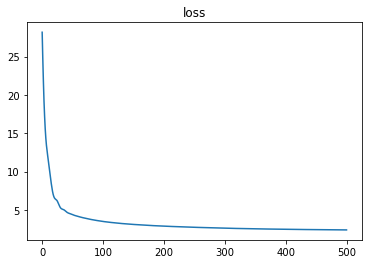

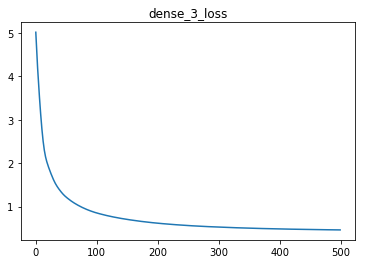

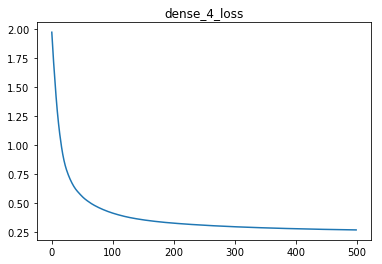

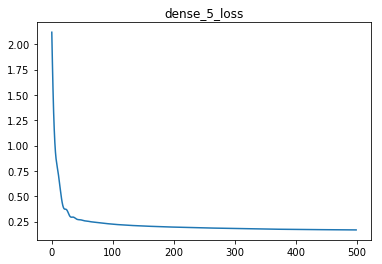

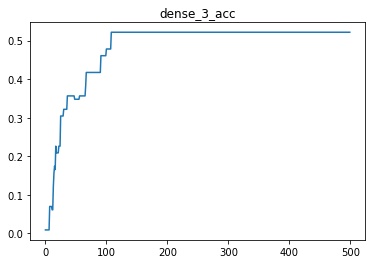

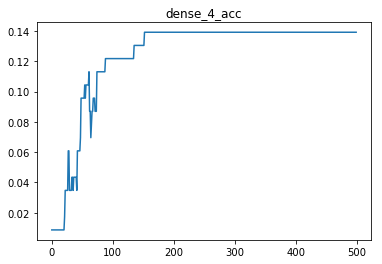

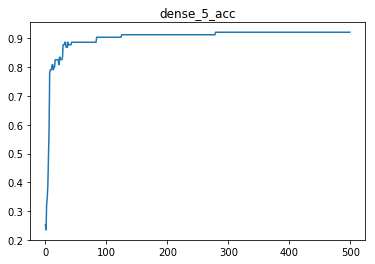

In [14]:
for k in h.history.keys():
    plt.plot(h.history[k])
    plt.title(k)
    plt.show()

[59.285167694091797, 55.448032379150391, 51.62286376953125, 47.823959350585938, 44.054378509521484, 40.320266723632812, 36.742965698242188, 33.123371124267578, 29.610389709472656, 26.237598419189453]


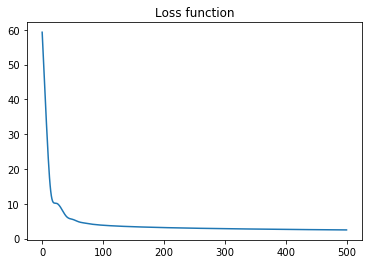

In [213]:
plt.plot(h.history['loss'])
plt.title('Loss function')
plt.show()

In [218]:
# Model utils
def build_input(path, data):
    out_a = np.zeros_like(data)
    out_b = np.zeros_like(data)
    out_a[:len(path)] = np.asarray(path)
    out_b[:len(path)] = data[path]
    out = np.hstack([out_a, out_b])
    out = out.reshape([1, -1])
    
    return out

def get_output(y):
    questions, answers, choice = y
    
    if np.argmax(choice) == 0:
        out_type = 'question'
        out_val = np.argmax(questions)
    else:
        out_type = 'answer'
        out_val = np.argmax(answers)
    
    return out_type, out_val

In [219]:
# Get random test
choice = random.choice(range(len(X)))
plate_name = idx2row[y[choice]]
plate_data = X[choice]
plate_best_path = plate_paths[choice]
print('Target plate: %s' % plate_name)
print('Optimal path of questions: %s' % [idx2col[i] for i in plate_best_path])

# Ask questions
test_path = []
i = 0
pred_type = 'question'

while pred_type != 'answer':
    if i == 0:
        pred_type = 'question'
        pred_val = first_question
    else:
        pred = model.predict(build_input(test_path, plate_data))
        pred_type, pred_val = get_output(pred)
        
    if pred_type == 'question':
        print('\nQuestion #%d' % (i + 1))
        print('%s (%s)' % (idx2col[pred_val], idx2answer[plate_data[pred_val]]))
    else:
        print('\nAnswer: ' + idx2row[pred_val])
        
    test_path.append(pred_val)
    i += 1

Target plate: Locro de zapallo
Optimal path of questions: ['Lleva papas?', 'Es comida marina?', 'Lleva carne de res?', 'Lleva pollo?', 'Lleva zapallo?']

Question #1
Lleva papas? (No)

Question #2
Es comida marina? (No)

Question #3
Lleva carne de res? (No)

Question #4
Lleva papas fritas? (No)

Answer: Rocoto relleno


In [250]:
answers[test_path]

array([ 1.])

In [1]:
#


In [95]:
y.shape

(24,)

In [ ]:
model.predict()

In [50]:
# out = merge([out_question, out_plate, out_choice], mode='concat')

In [42]:
out_question

<tf.Tensor 'Softmax_2:0' shape=(?, 19) dtype=float32>

In [43]:
out_plate

<tf.Tensor 'Softmax_3:0' shape=(?, 24) dtype=float32>

In [44]:
out_choice

<tf.Tensor 'Softmax_4:0' shape=(?, 2) dtype=float32>

In [195]:
# Custom loss function
from keras import backend as K

choice_penalty = 5

def custom_loss(y_true, y_pred):
    y_true_questions = y_true[:, :n_questions]
    y_true_answers = y_true[:, n_questions:-2]
    y_true_choice = y_true[:, -2:]
    y_pred_questions = y_pred[:, :n_questions]
    y_pred_answers = y_pred[:, n_questions:-2]
    y_pred_choice = y_pred[:, -2:]
    
    L_questions = K.categorical_crossentropy(y_true_questions, y_pred_questions)
    L_answers = K.categorical_crossentropy(y_true_answers, y_pred_answers)
    L_choice = K.cast(K.abs(K.argmax(y_pred_choice) - K.argmax(y_true_choice)), dtype='float32')
#     print(K.categorical_crossentropy(y_true, y_pred))
#     print(L_questions)
#     print(L_answers)
#     print(L_choice)
#     L = L_questions

#     L = (K.cast(K.abs(K.argmax(y_pred_choice) - 1), dtype='float32'))
#     L = K.cast(K.argmax(y_pred_choice), dtype='float32')
#     L = K.cast(K.argmax(y_pred_choice, axis=-1), dtype='float32')
#     L = y_pred_choice
#     L = K.cast(K.abs(K.argmax(K.cast(y_pred_choice, dtype='float32'), axis=-1)), dtype='float32')
    L = K.cast(K.argmax(y_pred_choice, axis=-1), dtype='float32')
    L = K.cast(K.argmax(K.cast(y_true_choice, dtype='float32'), axis=-1), dtype='float32')
#     L = K.cast(K.abs(K.argmax(y_pred_choice) - K.argmax(y_true_choice)), dtype='float32')
    print(L)
#     L = (K.cast(K.abs(K.argmax(y_pred_choice) - 1), dtype='float32') * L_questions)
#     print(L)
    
#     L = (K.cast(K.abs(K.argmax(y_pred_choice) - 1), dtype='float32') * L_questions) + \
#         (K.cast(K.argmax(y_pred_choice), dtype='float32') * L_answers)
#     L = (L_choice * choice_penalty) + (K.abs(L_choice - 1) * L_questions)
#     print(L)
    
    return K.mean(L)

model.compile(optimizer='adam', loss=custom_loss)
h = model.fit_generator(data_gen, gen_batch, 500, verbose=0)

Tensor("Cast_227:0", shape=(?,), dtype=float32)


ValueError: None values not supported.